# 프로젝트 : 자율주행 시스템
2024-07-15
이경규

<br>

### 데이터 : 
- 훈련 데이터: KITTI
- 테스트 데이터 : 첨부 이미지

### 모델 :  RetinaNet (w.Feature Pyramid Network)
- 백본 : ResNet50

### 목표 : 자율주행 시스템
- 자율 주행 시스템 구현
    - 입력 이미지로 부터 정지 조건에 대하여 "Stop" or "Go" 반환
    - 조건 : 사람이 한 명 이상 있는 경우 / 차량의 크기(width or height)가 300px이상인 경우
- 자율 주행 시스템 평가

### 0. 라이브러리

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/aiffel/aiffel/aiffel_quest'

### 1. 데이터 로드
[cvlibs - KITTI](http://www.cvlibs.net/datasets/kitti/)
- KITTI : cvlibs에서 제공하는 데이터 셋
- KITTI: tensorflow_datasets 에서 일부 제공
- 3D object detection 라벨 : 2D object detection + 깊이

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

### 1.1 데이터 셋 이미지 확인
- `tfds.show_examples` : 이미지 예시 확인
- 광각으로 촬영되어 다양한 각도의 물체를 확인

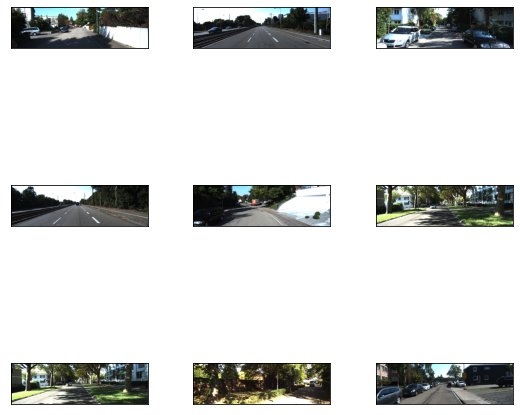

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

### 1.2 데이터셋 정보 확인
- training data : 6,347 / val : data 423 / test data : 711
- **label** : 
`alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated`

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/aiffel_quest/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'b

### 1.3 데이터셋 직접 확인
- **sample** : `ds_train.take(1)` 을 통해 데이터셋을 하나씩 뽑음
- 결과 해석
    - shape=(7,) : 7가지 객체 정보
    - `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated`

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([-1.56,  2.14,  2.21,  2.11,  2.01,  1.96], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.42517334, 0.41251206, 0.64573336, 0.46766505],
       [0.37224   , 0.        , 0.46832   , 0.04752013],
       [0.39485332, 0.05043478, 0.48541334, 0.1205314 ],
       [0.41941333, 0.11171497, 0.48904   , 0.16022544],
       [0.43210667, 0.14341384, 0.49584   , 0.18658616],
       [0.43274668, 0.17788245, 0.49442667, 0.21210144]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ 3.52,  2.89, 10.81],
       [ 1.43,  1.48,  3.33],
       [ 1.62,  1.6 ,  4.18],
       [ 1.48,  1.35,  3.93],
       [ 1.5 ,  1.62,  4.08],
       [ 1.65,  1.57,  3.82]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ -3.15,   1.87,  36.33],
       [-26.34,   2.66,  31.9

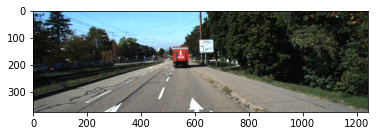

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

### 2. 바운딩 박스
[Pillow 라이브러리 - ImageDraw](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)

- object_bbox : 바운딩 박스 좌표를 포함한 numpy 배열
- `x_min`, `y_min`, `x_max`, `y_max` : 바운딩 박스의 좌표를 이미지 크기에 맞게 조정

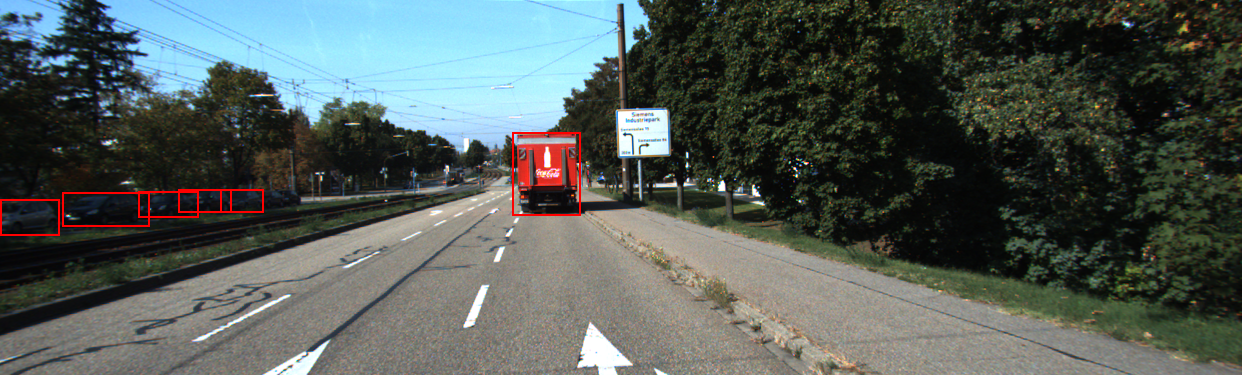

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.

def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 3. 데이터 파이프 라인
1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기 (Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계: [x_min, y_min, x_max, y_max] → [x_min, y_min, width, height] 수정

### 3.1 x,y 좌표 위치 교체
- [x_min, y_min, x_max, y_max] → [y_min, x_min, y_max, x_max]

In [7]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

### 3.2 이미지 크기 조정 및 패딩 추가
- **image_shape** : 이미지의 높이와 너비
    - `tf.shape(image)[:2]` : 높이와 너비
- **학습 시 최소 크기 랜덤 설정**
    - **min_side** : min_side_range 범위 내의 임의의 값
    - **ratio** : 이미지의 최소 측면을 min_side에 맞춤 / 이미지의 최대 측면을 max_side에 맞춤
    - **image** : ratio로 조정된 image_shape의 크기로 변환
- **패딩 추가**
    - **padded_image_shape** : 조정된 image의 크기를 stride 배수로 맞춤 ([0]:높이 [1]:너비)
    - `pad_to_bounding_box` : 패딩 추가

In [8]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024] # 학습시 사용할 수 있는 최소 크기의 범위
    stride = 128.0 # 패딩을 추가할 때 사용할 단위
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    # 학습시 최소 크기 랜덤 설정
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    # 패딩 추가
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

### 3.3 좌표계 수정
- [x_min, y_min, x_max, y_max] → [center_x, center_y, width, height]

In [9]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

### 3.4 수평 뒤집기
- [xmin, ymin, xmax, ymax] → [1.0 - xmax, ymin, 1.0 - xmin, ymax]

In [10]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1.0 - boxes[:, 2], boxes[:, 1], 1.0 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes

### 3.5 데이터 파이프라인 연결
- 앞서 정의한 파이프 라인 함수 연결 ⇒ 전처리 된 이미지, 바운딩 박스, class_id 반환
- bbox 좌표 크기 조정
    - image_shape[1] : 이미지의 높이
    - image_shape[0] : 이미지의 너비

In [11]:
def preprocess_data(sample):
    image = sample["image"]
    # 1.bbox 좌표를 x,y 위치 교체
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32) # class를 정수형으로 변환

    # 이미지 수평 뒤집기
    image, bbox = random_flip_horizontal(image, bbox)
    # 2. 이미지 크기 조정및 패딩 추가
    image, image_shape, _ = resize_and_pad_image(image)
    
    # bbox 좌표 크기 조정
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1], 
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    # 좌표계 수정
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### 4. Anchor box 생성
- **`__init__` : 클래스 초기화**
    - `aspect_ratios`: 앵커 박스의 가로세로 비율
    - `scales`: 앵커 박스의 크기를 조정하는 스케일
    - `_num_anchors`: 각 위치에서 생성할 앵커 박스의 수. 비율과 스케일의 조합 수
    - `_strides`: 각 특성 맵(feature map) 레벨의 스트라이드 값, 이미지 크기를 점진적으로 줄여가는 단계
    - `_areas`: 각 특성 맵 레벨에서의 앵커 박스 면적
    - `_anchor_dims`: 각 레벨에서의 앵커 박스 차원(너비와 높이)
- **`_compute_dims` : 앵커 박스 차원 계산**
    - `area`에 따라 앵커 박스의 너비와 높이를 계산
    - 각 비율에 대해 앵커 박스의 높이(`anchor_height`)와 너비(`anchor_width`)를 계산
    - `dims`는 각 앵커 박스의 크기를 나타내며, 스케일을 곱하여 다양한 크기의 앵커 박스를 생성
    - 결과적으로 각 레벨에서의 앵커 박스 차원을 반환
- **`_get_anchors` : 특정 레벨에서 앵커 박스 생성**
    - `feature_height`와 `feature_width`는 특성 맵의 높이와 너비
    - `rx`와 `ry`는 특성 맵의 각 위치에 대해 앵커 박스의 중심을 계산
    - `centers`는 각 위치에서의 앵커 박스 중심 좌표
    - `dims`는 각 앵커 박스의 차원(너비와 높이)
    - `anchors`는 중심 좌표와 차원을 결합하여 최종 앵커 박스를 생성
    - 결과적으로 앵커 박스는 `[feature_height * feature_width * self._num_anchors, 4]` 형태로 반환
- **`get_anchors` : 이미지에서 앵커 박스 생성**
    - `image_height`와 `image_width`는 입력 이미지의 높이와 너비
    - 여러 레벨에 대해 앵커 박스를 생성
    - `_get_anchors` 메서드를 호출하여 각 레벨에서 앵커 박스를 생성
    - 생성된 앵커 박스를 하나의 텐서로 결합하여 반환

In [12]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

### 4.1 바운딩 박스 좌표 변환
- boxes : [center_x, center_y, width, height] → [x_min, y_min, x_max, y_max]
    - 좌상단 좌표: boxes[..., :2] - boxes[..., 2:] / 2.0
    - 우하단 좌표: boxes[..., :2] + boxes[..., 2:] / 2.0

In [13]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

### 4.2 IoU 계산
- input boxes1,2 : [center_x, center_y, width, height] → corners : [x_min, y_min, x_max, y_max]
    - intersection_area : 교집합 영역의 면적
    - union_area : 합집합 영역의 면적
- return : IoU (0~1 사이)

In [14]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)

    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]

    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8 )
        
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

### 4.3 훈련이 가능한 형식으로 변경

- 객체 탐지 모델을 학습시키기 위한 데이터 준비 과정
- **`_match_anchor_boxes` : 앵커 박스와 GT 박스 매칭**
    - `matched_gt_idx` : 각 앵커 박스에 대해 매칭된 GT 박스의 인덱스
    - `positive_mask`: IoU가 `match_iou` 이상인 앵커 박스를 양성으로 표시
    - `negative_mask`: IoU가 `ignore_iou` 이하인 앵커 박스를 음성으로 표시
    - `ignore_mask`: 양성과 음성이 아닌 앵커 박스를 무시
- **앵커 박스와 ground truth 박스 사이의 IoU를 계산**
    - **`_compute_box_target` : 바운딩 박스 타겟 계산**
        - `box_target`: 앵커 박스와 매칭된 GT 박스 간의 오프셋을 계산 ⇒ 정규화 (학습 가능하게)
- **각 앵커 박스에 적절한 레이블을 할당**
    - **`_encode_sample` : 샘플 인코딩**
        - `anchor_boxes`: 이미지 크기에 맞게 앵커 박스를 생성
        - `matched_gt_idx`, `positive_mask`, `ignore_mask`: 앵커 박스와 GT 박스를 매칭
        - `matched_gt_boxes`: 매칭된 GT 박스
        - `box_target`: 바운딩 박스 오프셋을 계산
        - `matched_gt_cls_ids`: 매칭된 클래스 ID
        - `cls_target`: 양성, 음성, 무시 마스크를 사용하여 클래스 타겟을 설정
        - `label`: 바운딩 박스 오프셋과 클래스 타겟을 결합하여 최종 레이블을 생성
- **모델이 학습할 수 있는 형식으로 변환**
    - **`encode_batch` : 배치 인코딩**
        - `images_shape`: 배치 이미지의 크기
        - `batch_size`: 배치 크기
        - `labels`: 텐서 배열을 생성하여 각 샘플의 레이블을 저장
        - 각 샘플에 대해 `_encode_sample`을 호출하여 레이블을 생성하고, 이를 텐서 배열에 저장
        - `batch_images`: 배치 이미지를 ResNet 모델에 맞게 전처리
        - 최종적으로 배치 이미지와 레이블을 반환

In [15]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

# RetinaNet

[Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)

- focal loss, FPN(Feature Pyramid Network)가 적용된 네트워크를 사용한 detector model
    - 2-stage detector(Faster-RCNN)보다 빠르지만 낮은 성능의 문제를 가진 1-stage detector (YOLO, SSD)를 해결

## Focal Loss

> 물체를 배경보다 더 잘 학습 하자 == 물체인 경우 Loss를 작게 만들자
> 


- 문제점 : 기존 1-stage detection 모델은 물체와 배경을 담고 있는 모든 grid를 한 번에 학습
⇒ 물체보다 많은 배경을 학습
- 해결 방법 : focal loss를 통해 클래스 간의 불균형을 해결
    - Cross Enthory : $CE(p_t) =-log(p_t)$
    - Focal Loss : $FL(p_t)=-(1-p_t)^\gamma log(p_t)$

    

## FPN (**Feature Pyramid Network)**

> 여러 층의 특성 맵(feature map)을 다 사용해보자
> 



- 다양한 스케일의 객체를 효과적으로 탐지하기 위해 네트워크의 여러 레이어의 피쳐 맵을 결합
    
    : 깊은 레이어의 넓은 receptive field, 얕은 레이어의 좁은 receptive field를 결합
    
    ⇒ 다양한 크기의 객체를 효과적으로 탐지
    


- P3부터 P7까지의 pyramid level을 생성 (Anchor : A개)
    - **Classification Subnet** : K개의 class에 대해 KA개의 채널을 사용
    - **Box Regression Subnet** : 4A개의 채널을 사용

### 5. 모델 작성
### 5.1 Feature Pyramid Network
- RetinaNet에서는 FPN(Feature Pyramid Network)를 사용
    - 다양한 해상도의 피쳐 맵을 생성
- ResNet layer
    - c3, c4, c5
    - ResNet 같은 백본 네트워크를 사용하여 다양한 레벨의 피쳐 맵을 추출
- FPN layer
    - p3, p4, ..., p7
    - 업샘플링 : 1x1과 3x3 컨볼루션의 피쳐 맵을 조정하고 결합

In [16]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

### 5.2 추론을 위한 Sequential 모델 생성
- input : [height, width, 256]
    -  height와 width는 유동적
- `tf.initializers.RandomNormal(0.0, 0.01)` : 컨볼루션 레이어의 가중치(커널)를 평균 0.0, 표준 편차 0.01로 초기화
- 중간 컨볼루션 레이어와 ReLU 추가
    - 256개의 필터와 3x3 커널 크기
    - ReLU 활성화 함수를 추가하여 비선형성을 도입
- 최종 컨볼루션 레이어 추가
    - output : output_filters 개의 필터와 3x3 커널 크기

In [17]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

### 5.3 백본 ResNet50 : 특정 레이어의 출력 반환
- ResNet50 모델을 백본(backbone)으로 설정
- 특정 레이어의 출력을 반환하는 모델을 생성
- 백본 모델 : 객체 검출(Object Detection) 모델에서 특징 추출기(feature extractor)로 사용

In [18]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

### 5.4 RetinaNet 모델 정의
- Backbone
- FPN
- classification용 head
- box용 head 

In [19]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

### 5.5 Loss 설정
- **Box Regression** : Smooth L1 Loss
- **Classification Loss** : Focal Loss (RetinaNet)

In [20]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss


### 6. 모델 학습
### 6.1 RetinaNet 모델 인스턴스

In [21]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

### 6.2 학습률 및 모델 컴파일
- 적절한 LR 설정
- model compile
    loss: RetinaNetLoss(num_classes)
    optimizer : SGD
- 학습률을 특정 단계에서 변화
    - 모델이 학습하는 동안 더 안정적이고 효과적으로 학습

In [22]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

### 6.3 데이터 전처리를 위한 파이프라인
- 데이터 셋 로드
- 전처리
- 배치 단위 준비

In [23]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

### 6.4 모델 학습

In [ ]:
model_dir = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest6/model'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 1

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

### 7. 결과 확인
### 7.1 학습 모델 로드

In [25]:
model_dir = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest6/model'
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

### 7.2 모델의 추론 결과 처리 함수
- `max_detections_per_class` : 100개의 후보
- `tf.image.combined_non_max_suppression` : NMS
    - `nmsed_boxes`, `nmsed_scores`, `nmsed_classes`, `valid_detections`

In [26]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

### 7.3 추론 모델

In [27]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.43)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

### 7.4 추론 결과 시각화

In [28]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

### 7.5 추론 데이터 전처리
- 학습 데이터의 전처리와 다름

In [29]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

### 7.6 추론 결과 시각화
- 예측 바운딩 박스의 위치
- 바운딩 박스가 특정 클래스에 속할 확률

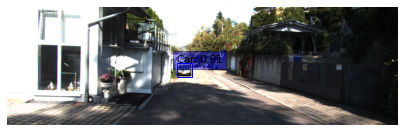

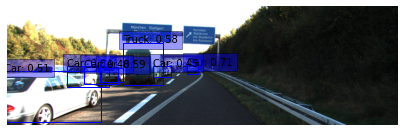

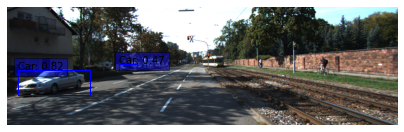

In [30]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(3):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# 자율 주행 보조 시스템
## 1. 자율 주행 시스템 생성

- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환
- 조건
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

### 1.1 클래스 인덱스와 이름 매핑

In [31]:
class_names = ds_info.features['objects']['type'].names
int2str = {i: name for i, name in enumerate(class_names)}

print("Class index to name mapping:")
for index, name in int2str.items():
    print(f"{index}: {name}")

Class index to name mapping:
0: Car
1: Van
2: Truck
3: Pedestrian
4: Person_sitting
5: Cyclist
6: Tram
7: Misc


In [32]:
int2str = {i: name for i, name in enumerate(class_names)}
int2str

{0: 'Car',
 1: 'Van',
 2: 'Truck',
 3: 'Pedestrian',
 4: 'Person_sitting',
 5: 'Cyclist',
 6: 'Tram',
 7: 'Misc'}

### 1.2 자율주행 시스템
- person_detected : Pedestrian, Person_sitting, Cyclist
- large_vehicle_detected : Car, Van, Truck > 300px

In [33]:
def self_drive_assist(img_path, size_limit=300):
    # 이미지 로드
    image = Image.open(img_path)
    image = tf.convert_to_tensor(np.array(image), dtype=tf.float32)

    # 이미지 전처리
    input_image, ratio = prepare_image(image)

    # 객체 감지 모델 로드 및 추론 (모델 로드 코드는 생략)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str[int(x)] for x in detections.nmsed_classes[0][:num_detections]
    ]
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio

    # 조건 검사
    person_detected = "Pedestrian" in class_names or "Person_sitting" in class_names or "Cyclist" in class_names

    large_vehicle_detected = False

    for i, box in enumerate(boxes):
        ymin, xmin, ymax, xmax = box
        width = xmax - xmin
        height = ymax - ymin
        if width >= size_limit or height >= size_limit:
            if class_names[i] in ["Car", "Van", "Truck"]:
                large_vehicle_detected = True
                break

    # 조건에 따른 반환 값 결정
    if person_detected or large_vehicle_detected:
        return "Stop"
    else:
        return "Go"

### 2. 자율주행 시스템 평가
- 10장의 이미지에 대하여 pred와 조건이 맞을 경우 +10

In [35]:
test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go")
    ]
def test_system(func, test_set=test_set):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
        print(image_file, pred)
    print(f"{score}점입니다.")

In [36]:
def detect_and_visualize(img_path, model):
    # 이미지 로드
    image = Image.open(img_path)
    image = tf.convert_to_tensor(np.array(image), dtype=tf.float32)

    # 이미지 전처리
    input_image, ratio = prepare_image(image)

    # 객체 감지 수행
    detections = model.predict(input_image)
    num_detections = detections[3][0]  # valid_detections
    class_names = [
        int2str.get(int(x), "Unknown") for x in detections[2][0][:num_detections]  # nmsed_classes
    ]
    boxes = detections[0][0][:num_detections] / ratio  # nmsed_boxes
    scores = detections[1][0][:num_detections]  # nmsed_scores
    # 예측된 bounding box 개수
    predicted_box_count = len(boxes)
    
    # 예측 결과 시각화
    visualize_detections(image, boxes, class_names, scores)
    # 결과 출력
    print(f"Predicted bounding box count: {predicted_box_count}")

stop_1.png Stop
stop_2.png Stop
stop_3.png Stop
stop_4.png Stop
stop_5.png Stop
go_1.png Go
go_2.png Go
go_3.png Go
go_4.png Go
go_5.png Go
100점입니다.


stop_1.png


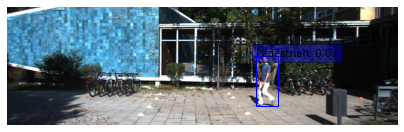

Predicted bounding box count: 1

stop_2.png


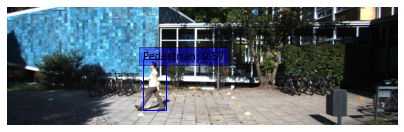

Predicted bounding box count: 1

stop_3.png


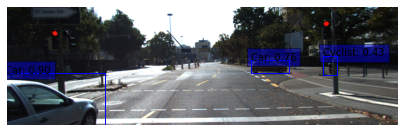

Predicted bounding box count: 3

stop_4.png


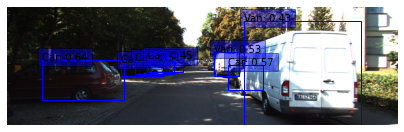

Predicted bounding box count: 7

stop_5.png


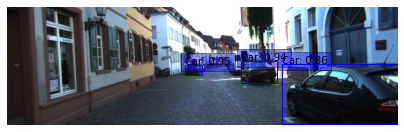

Predicted bounding box count: 3

go_1.png


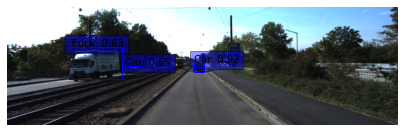

Predicted bounding box count: 3

go_2.png


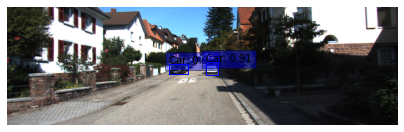

Predicted bounding box count: 2

go_3.png


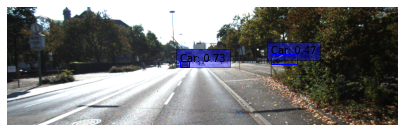

Predicted bounding box count: 2

go_4.png


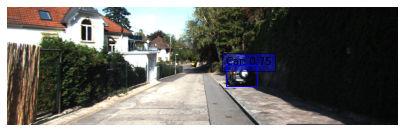

Predicted bounding box count: 1

go_5.png


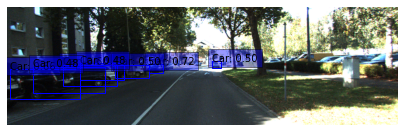

Predicted bounding box count: 7



In [38]:
test_system(self_drive_assist,test_set) 
print()
print()
work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
for image_file, answer in test_set:
    image_path = work_dir + '/' + image_file
    print(image_file)
    detect_and_visualize(image_path, inference_model)
    print()

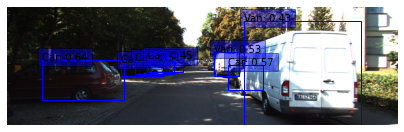

Predicted bounding box count: 7


In [39]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/stop_4.png'
detect_and_visualize(img_path, inference_model)

### 추론 개선
**잘못 예측**
- stop_4.png의 예측결과 오류
- 오른쪽 하얀색 차의 bbox가 생성되지 않음
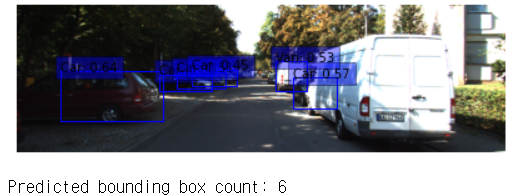

<br>

**의견**
1. 하얀색 차가 오른쪽 하얀 건물과 빛을 받아 잘 예측되지 못했다.
2. 앵커 박스의 크기가 부족했다. (큰 객체에 대한)
3. nms에서 iou threshold 값이 작아 바운딩 박스가 제거 되었다.
4. nms에서 confidence score가 잘 못 설정 되어있었다.

<br>

**1. 개선 시도**
- nms iou 임계값을 증가시켜 바운딩 박스가 제거되는 양을 줄였다.
- 기대효과 : 더 많은 바운딩 박스가 생길 것 이다.
- `nms_iou_threshold` : 0.5->0.9
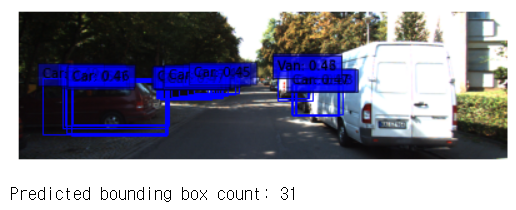
- 바운딩 박스의 양이 늘어났지만, 예측이 되었던 객체에 대한 bbox만 늘어났다.

<br>

**2. 개선 시도**
- `match_iou`와 `ignor_iou` 값을 낮췄다.
- 기대효과 : 더 많은 앵커 박스를 양성으로 간주할 것이다.
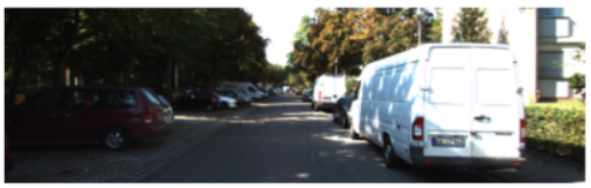
- 어느 바운딩 박스가 생기지 않았다. <= 훈련이 잘 진행될 수 없었다

<br>

**3. 개선 시도**
- `confidence_threshold`를 낮췄다.
- 기대효과 : 신뢰도가 낮은 바운딩 박스도 포함되어 탐지되는 바운딩 박스가 증가한다.
- 0.5

- 0.4

- 0.45
- 0.43
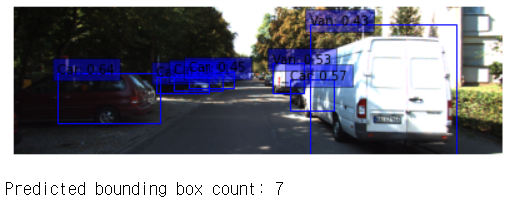


### 데이터 추가
- car1, car2, car3, car4

stop_1.png Stop
stop_2.png Stop
stop_3.png Stop
stop_4.png Stop
stop_5.png Stop
go_1.png Go
go_2.png Go
go_3.png Go
go_4.png Go
go_5.png Go
car1.png Stop
car2.png Stop
car3.png Stop
car4.png Go
100점입니다.


stop_1.png


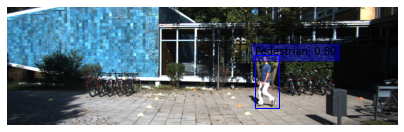

Predicted bounding box count: 1

stop_2.png


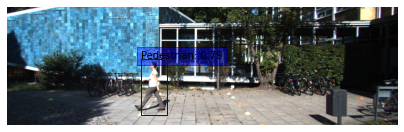

Predicted bounding box count: 1

stop_3.png


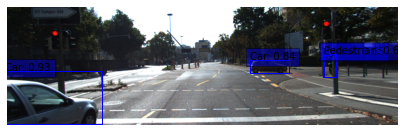

Predicted bounding box count: 4

stop_4.png


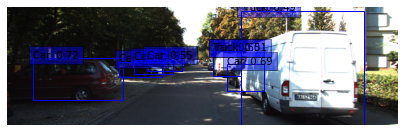

Predicted bounding box count: 8

stop_5.png


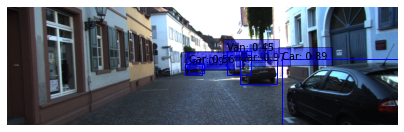

Predicted bounding box count: 5

go_1.png


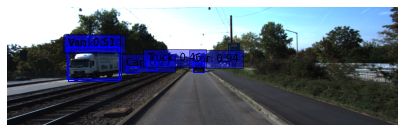

Predicted bounding box count: 5

go_2.png


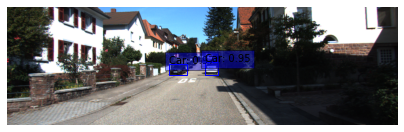

Predicted bounding box count: 2

go_3.png


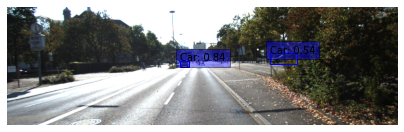

Predicted bounding box count: 2

go_4.png


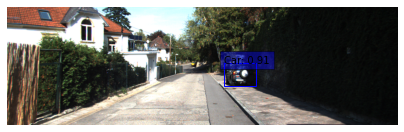

Predicted bounding box count: 1

go_5.png


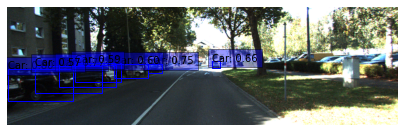

Predicted bounding box count: 7

car1.png


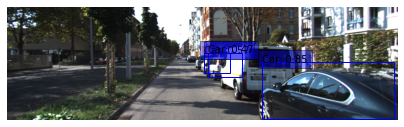

Predicted bounding box count: 3

car2.png


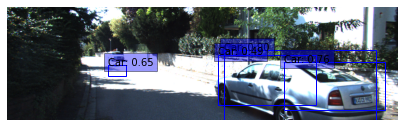

Predicted bounding box count: 4

car3.png


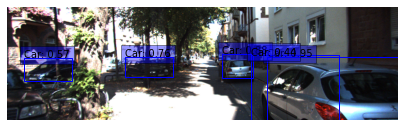

Predicted bounding box count: 5

car4.png


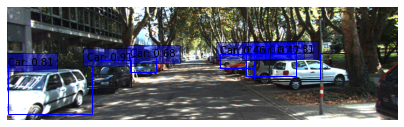

Predicted bounding box count: 7



In [ ]:
test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
        ("car1.png", "o"),
        ("car2.png", "o"),
        ("car3.png", "o"),
        ("car4.png", "o")
    ]
test_system(self_drive_assist,test_set) 
print()
print()
for image_file, answer in test_set:
    image_path = work_dir + '/' + image_file
    print(image_file)
    detect_and_visualize(image_path, inference_model)
    print()

### 회고
- 배운점 : object dectection의 anchor 설정과 retina 모델의 fpn에 대해 알 수 있었다.
- 아쉬운 점 : 이미지를 추가 하였을 때 분류결과가 좋지 않은 점이 아쉬웠다. - 학습 에폭의 부족?
- 느낀 점 : 학습량이 낮을 경우 모델의 자신감인 confidence 임계값을 수정하여 바운딩 박스를 설정할 수 있었다.
- 어려웠던 점 : 잘 못 예측된 이미지의 원인에 대한 분석과 파라미터들의 수정에 어려움이 있었다.